# Report Notebook 

To compare the performances in reconstruction of different models

In [1]:
import torch
import numpy as np
import wandb
from classes.VAE import VAE, VAEGAN
from classes.VQVAE import VQVAE

import torchvision.transforms.functional as TVF
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose,ToTensor,Resize,PILToTensor
from torchvision.io import read_image
from torchvision.utils import make_grid
from torchsummary import summary

from imutils import paths
import matplotlib.pyplot as plt

from utils.utils import *
from dall_e import map_pixels, unmap_pixels, load_model


torch.set_grad_enabled(False) # to save memory


In [2]:
# Get cpu or gpu device for training.
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda:0 device


## Load Models

In [3]:
## VAE

encoder_architecture=[[1,512],[1,256],[1,128],[1,64],[1,32]]
decoder_architecture=[[3,64],[2,128],[1,256],[0,384],[0,512]]

latent_dim=1024
input_dim=(3,128,128)

vae=VAE(input_dim=input_dim,latent_dim=latent_dim,encoder_architecture=encoder_architecture,decoder_architecture=decoder_architecture)
vae.load_state_dict(torch.load(r"models/vae/model.ckp"))

/home/matteo/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


<All keys matched successfully>

In [4]:
encoder_architecture=[[3,256],[1,256],[1,128],[1,64]]
decoder_architecture=[[1,64],[1,128],[1,256],[3,256]]



latent_dim=512
input_dim=(3,128,128)

num_embeddings=512


vqvae=VQVAE(input_dim=input_dim,latent_dim=latent_dim,num_embeddings=num_embeddings,encoder_architecture=encoder_architecture,decoder_architecture=decoder_architecture)
vqvae.load_state_dict(torch.load(r"models/vqvae/model.pt"))

<All keys matched successfully>

In [5]:
encoder_architecture=[[0,512],[1,256],[1,128],[1,64]]
decoder_architecture=[[0,64],[0,128],[0,256],[0,512]]

discriminator_architecture=[[0,64],[0,128],[0,256],[0,512]]
discriminator_dense=64
latent_dim=1024
input_dim=(3,128,128)

vaegan=VAEGAN(input_dim=input_dim,latent_dim=latent_dim,encoder_architecture=encoder_architecture,decoder_architecture=decoder_architecture,discriminator_architecture=discriminator_architecture,discriminator_dense=discriminator_dense)
vaegan.load_state_dict(torch.load(r"models/vaegan/model.ckp"))

<All keys matched successfully>

## Pretrained Models

VQGAN : https://github.com/CompVis/taming-transformers

DALL-E : https://github.com/openai/DALL-E

In [6]:
config1024="taming_transformers/logs/vqgan_imagenet_f16_1024/configs/model.yaml"
model1024 = "taming_transformers/logs/vqgan_imagenet_f16_1024/checkpoints/last.ckpt"

vqgan=init_vqgan(config1024,model1024)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


## Dataloaders


In [7]:
images_dir=r"C:\Users\matte\Dataset\tor_vergata\Dataset\Img\img_align_celeba"
images_dir=r"/home/matteo/NeuroGEN/Dataset/Img/img_align_celeba"

BS=10

In [8]:
class ImageDataset(Dataset):
    def __init__(self, img_list, transform=None):
        self.img_list = img_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_path = self.img_list[idx]
        image = read_image(img_path)
        if self.transform:
            image = self.transform(image)/255.
        return image

In [9]:
transforms=Compose([
 Resize((128,128)),
])



In [10]:
print("[INFO] loading image paths...")
imagePaths = list(paths.list_images(images_dir))


train_len=int(0.8*len(imagePaths))  #0.8
val_len=int(0.1*len(imagePaths))     #0.1
test_len=int(0.1*len(imagePaths))

train_imgs=imagePaths[:train_len]                                #      80% for training
val_imgs=imagePaths[train_len:train_len+val_len]                 #      10% for validation
test_imgs=imagePaths[train_len+val_len:]                         #      10% for testing

print(f"[TRAINING]\t {len(train_imgs)}\n[VALIDATION]\t {len(val_imgs)}\n[TEST]\t\t {len(test_imgs)}")

[INFO] loading image paths...
[TRAINING]	 138545
[VALIDATION]	 17318
[TEST]		 17319


In [11]:
train_dataset=ImageDataset(train_imgs,transform=transforms)
val_dataset=ImageDataset(val_imgs,transform=transforms)
test_dataset=ImageDataset(test_imgs,transform=transforms)

train_dataloader=DataLoader(train_dataset, batch_size=BS, shuffle=True)
val_dataloader=DataLoader(val_dataset, batch_size=BS)
test_dataloader=DataLoader(test_dataset, batch_size=BS)


In [12]:
x=next(iter(test_dataloader))
x=x.to(device)


In [13]:
vae.to(device)
vqvae.to(device)
vaegan.to(device)


print("VAE, VQVAE, VAEGAN ok")

VAE, VQVAE, VAEGAN ok


In [14]:
vqgan.to(device)
print("VQ GAN ok")

VQ GAN ok


In [15]:
encoder_dalle = load_model("dalle/encoder.pkl").to(device)
decoder_dalle = load_model("dalle/decoder.pkl").to(device)



## Predict Images in the test set

In [16]:
def rescale(x,size=128):
    return torch.nn.functional.interpolate(x,size,mode="bilinear")

In [17]:
x_vae=vae(x)
loss,x_vqvae,_=vqvae(x)
x_vaegan=vaegan(x)

In [18]:
#pretrained
x_vqgan,_=vqgan(preprocess_vqgan(x))
x_vqgan=rescale(x_vqgan)

/home/matteo/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


In [19]:
x.shape

torch.Size([10, 3, 128, 128])

In [20]:
x_dalle=reconstruct_with_dalle(preprocess_dalle(x,map_dalle=True),encoder_dalle,decoder_dalle)
x_dalle=rescale(x_dalle)

DALL-E: latent shape: torch.Size([10, 40, 40])


In [21]:
print(x_vae.shape,x_vqvae.shape,x_vaegan.shape,x_vqgan.shape,x_dalle.shape)


torch.Size([10, 3, 128, 128]) torch.Size([10, 3, 128, 128]) torch.Size([10, 3, 128, 128]) torch.Size([10, 3, 128, 128]) torch.Size([10, 3, 128, 128])


In [22]:
def tensor2img(x):
    return x.permute(1,2,0).detach().cpu().numpy()

In [23]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = TVF.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        


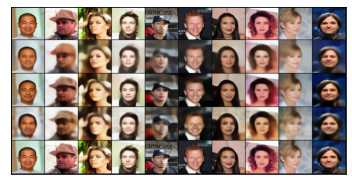

In [25]:
imgs=torch.concat([x,x_vae,x_vqvae,x_vaegan,x_dalle])

grid=make_grid(imgs,nrow=len(x))
show(grid)


In [28]:
table=wandb.Table(columns=["Original","VAE","VQVAE","VAEGAN","VQGAN","DALLE"])

for imgs in (zip(x,x_vae,x_vqvae,x_vaegan,x_vqgan,x_dalle)):
    img,img_vae,img_vqvae,img_vaegan,img_vqgan,img_dalle=imgs
    
    table.add_data(wandb.Image(tensor2img(img)),wandb.Image(tensor2img(img_vae)),wandb.Image(tensor2img(img_vqvae)),wandb.Image(tensor2img(img_vaegan)),wandb.Image(tensor2img(img_vqgan)),wandb.Image(tensor2img(img_dalle)))

In [29]:
wandb.init(project="NeuroGEN_Pytorch",name="Report")
wandb.log({"models":table})

## Store additional information of number of parameters and so on

In [30]:
##VAE
vae_encoder_architecture=[[1,512],[1,256],[1,128],[1,64],[1,32]]
vae_decoder_architecture=[[3,64],[2,128],[1,256],[0,384],[0,512]]
vae_latent_dim=1024
vae_epochs=20
vae_parameters=22794952

##VQ VAE
vqvae_encoder_architecture=[[3,256],[1,256],[1,128],[1,64]]
vqvae_decoder_architecture=[[1,64],[1,128],[1,256],[3,256]]
vqvae_latent_dim=512
vqvae_num_embeddings=512
vqvae_epochs=32
vqvae_parameters= 9392000+9877639+vqvae_latent_dim*vqvae_num_embeddings

##VAEGAN
vaegan_encoder_architecture=[[0,512],[1,256],[1,128],[1,64]]
vaegan_decoder_architecture=[[0,64],[0,128],[0,256],[0,512]]
vaegan_discriminator_architecture=[[0,64],[0,128],[0,256],[0,512]]
vaegan_discriminator_dense=64
vaegan_latent_dim=1024
vaegan_epochs=30
vaegan_parameters=13495168+7031239+6951106

In [31]:
print(vqvae_num_embeddings)

512


In [32]:
info_table=wandb.Table(columns=["encoder","decoder","discriminator","latent_dim","num_embeddings","epochs","parameters"])

info_table.add_data(vae_encoder_architecture,vae_decoder_architecture,None,vae_latent_dim,None,vae_epochs,vae_parameters)
info_table.add_data(vqvae_encoder_architecture,vqvae_decoder_architecture,None,vqvae_num_embeddings,vqvae_latent_dim,vqvae_epochs,vqvae_parameters)
info_table.add_data(vaegan_encoder_architecture,vaegan_decoder_architecture,vaegan_discriminator_architecture,vaegan_latent_dim,None,vaegan_epochs,vaegan_parameters)
wandb.log({"info":info_table})

In [33]:
i=torch.nn.functional.interpolate(x,320,mode="bilinear")
i.shape

/home/matteo/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


torch.Size([10, 3, 320, 320])